In the lecture, we discussed the simple genetic algorithm. Now, we will try to use it to solve two simple problems - OneMAX and subset sum.

In the end, we will discuss the `deap` library, that can be used for implementation of more complex evolutionary algorithms.

The implementation is very simple, we will start by writing the high-level version of the algorithm (it is almost a pseudo-code).

In [2]:
import numpy as np

def evolution(pop_size, ind_size, max_gen, fitness, cx_pb = 0.8, mut_pb=0.1, per_bit_pb = 0.2):
    population = random_population(pop_size, ind_size)
    log = []
    for i in range(max_gen):
        fit = [fitness(ind) for ind in population]
        log.append(max(fit))
        mating_pool = selection(population, fit, pop_size)
        offspring = crossover(mating_pool, cx_pb)
        offspring = mutation(offspring, mut_pb, per_bit_pb)
        population = offspring[:] # shallow copy
    
    fit = list(map(fitness, population))
    best = population[np.argmax(fit)]
    return best, population, log

Now we need to write implementations of the functions used above. We start by initializing a random population - we will only consider individuals that are lists of 1's and 0's.

In [3]:
import random

def random_population(pop_size, ind_size):
    pop = []
    for _ in range(pop_size):
        ind = [0 if random.random() < 0.5 else 1 for _ in range(ind_size)]
        pop.append(ind)
    
    return pop

random_population(5, 10)

[[1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
 [0, 1, 0, 0, 1, 0, 0, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0, 1, 0, 0, 0, 0]]

Next, we implemnt the roulette-wheel selection - it's simple, the `random` module contains the `choices` function, which does exactly what we need.

In [4]:
import copy

def selection(pop, fit, N):
    return copy.deepcopy(random.choices(pop, weights=fit, k=N)) # make a deep copy so that
                                                                # we have unique indivduals

Now we implement the one-point crossover and a mutation that changes random bits (bit flip mutation). For both operators, we expect to receive the entire population.

In [6]:
def crossover(pop, cx_pb = 0.8):
    new_pop = []
    for i in range(len(pop)//2):
        
        o1 = copy.deepcopy(pop[2*i])
        o2 = copy.deepcopy(pop[2*i + 1])
        
        if random.random() < cx_pb: # crossover probability
            point = random.randrange(0, len(o1))
            o2_start = o2[:point]
            o2[:point] = o1[:point]
            o1[:point] = o2_start[:]
        
        new_pop.append(o1)
        new_pop.append(o2)
    
    return new_pop

def mutation(pop, mut_pb = 0.1, per_bit_pb = 0.2):
    new_pop = []
    for ind in pop:
        
        o = copy.deepcopy(ind)
        
        if random.random() < mut_pb: # mutation probability
            o = [1-x if random.random() < per_bit_pb else x for x in o] # change the bit to the othex value with per_bit_pb probability
        
        new_pop.append(o)
    
    return new_pop

import pprint
pop = random_population(6, 10)
print('population')
pprint.pprint(pop)
print('after crossover')
pprint.pprint(crossover(pop))
print('after mutation')
pprint.pprint(mutation(pop, mut_pb=1.0))

population
[[0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 1]]
after crossover
[[1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
 [0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 0, 1, 1, 0, 0, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 1, 1]]
after mutation
[[0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
 [1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
 [1, 1, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 1]]


And that completes the algorithm. We only need to write a fitness function. We want to solve the OneMAX problem - fitness will therefore be the number of 1s in an individual.

In [7]:
def onemax(ind):
    return sum(ind)

pop = random_population(6, 10)
fit = [onemax(ind) for ind in pop]
for i,f in zip(pop, fit):
    print((i, f))

([0, 1, 1, 0, 0, 1, 0, 0, 0, 0], 3)
([0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 2)
([0, 0, 1, 1, 0, 1, 1, 1, 0, 1], 6)
([1, 0, 0, 1, 0, 0, 0, 1, 0, 0], 3)
([0, 1, 0, 0, 0, 0, 0, 1, 1, 1], 4)
([1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 2)


Let's start our algorithm and see how it works.

In [8]:
best, pop, log = evolution(pop_size = 100, ind_size = 50, max_gen = 50, fitness = onemax)

best fitness:  40
best:  [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


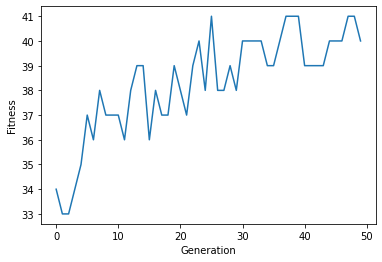

In [9]:
print('best fitness: ', onemax(best))
print('best: ', best)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(log)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

## Exercise

Try to adapt the algorithm above so that it solves the subset sum problem, i.e. find a subset of a givet set, such that its sum is exactly a given number. In the optimization version of this problem, we aim to minimize the difference between the sum of the subset and the given value.

You can generate the input randomly.

In [10]:
input_set = [random.randrange(0,50) + 100 for _ in range(100)] # 100 random numbers between 100 and 150
number = sum(input_set)//2
print(number, input_set)

6266 [113, 148, 115, 118, 144, 147, 105, 145, 111, 146, 145, 110, 127, 145, 104, 149, 143, 147, 147, 133, 147, 125, 133, 119, 136, 129, 123, 137, 110, 101, 119, 105, 120, 144, 110, 120, 126, 104, 101, 109, 125, 140, 138, 143, 138, 101, 141, 148, 140, 128, 149, 102, 113, 131, 120, 137, 102, 149, 140, 136, 121, 108, 125, 125, 108, 112, 135, 110, 124, 132, 115, 141, 105, 126, 116, 115, 108, 146, 100, 127, 133, 102, 136, 118, 139, 113, 130, 107, 112, 142, 117, 148, 106, 141, 140, 114, 117, 128, 101, 108]


## `deap`library 

We saw that implementing an evolutionary algorithms is simple, however, very often it is better to use an existing library to simplify the implementation (and avoid bugs). One of the most popular libraries is `deap`. Its tutorial is well-written and - [contains the same problem we solved above][1].

  [1]: https://deap.readthedocs.io/en/master/examples/ga_onemax.html